In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import torch.nn as nn
from torchvision import models, transforms, utils
from torchvision.transforms.functional import normalize, resize, to_pil_image
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from tqdm import tqdm

In [7]:
test_df = pd.read_csv('DDR-dataset/DR_grading/test.txt', sep=' ', header=None, names=['image', 'label'])
test_df = test_df.query('label != 5')
test_df['path'] = test_df['image'].apply(lambda x: os.path.join('DDR-dataset/DR_grading/test_preprocessed', x))

In [8]:
x_test = test_df['path']
y_test = test_df['label']

In [9]:
class CustomImageTestDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths.iloc[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image

# Define data augmentation transformations
aug_transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=360),
    v2.RandomPerspective(distortion_scale=0, p=1, interpolation=3),
    v2.RandomAffine(degrees=0, translate=(0, 0), scale=(1, 1), shear=0),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0, hue=0),
])

# Define the main transformation pipeline
transform = v2.Compose([
    v2.Resize((224, 224)),
    # v2.RandomApply([aug_transforms], p=0.5),  # Apply augmentations with 50% probability
    # v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create custom datasets and dataloaders for training and validation
test_dataset = CustomImageTestDataset(x_test, transform=transform)

test_dataloader = DataLoader(test_dataset, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


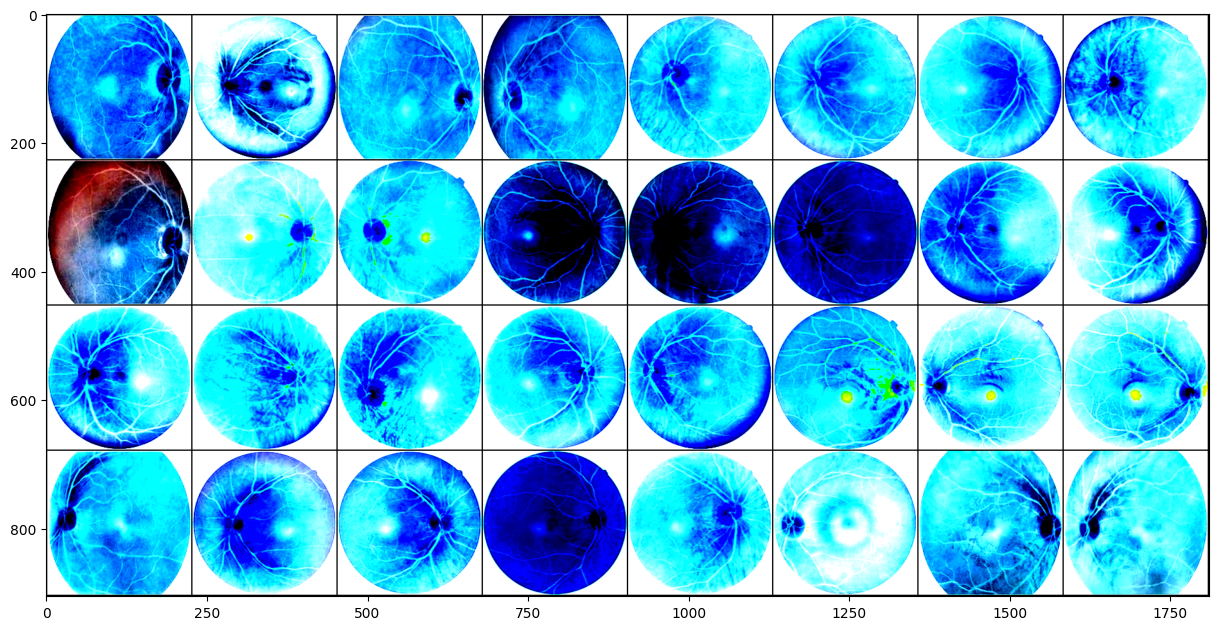

In [10]:

def show_batch(batch):
    images = batch
    grid_img = utils.make_grid(images, nrow=8)
    grid_img = np.transpose(grid_img, (1, 2, 0))
    # print(images.size())
    plt.figure(figsize=(15, 15))
    plt.imshow(grid_img)
    plt.show()

# Iterate over the train_dataloader and visualize a batch
for batch in test_dataloader:
    show_batch(batch)
    break  # Stop after visualizing the first batch

In [11]:
from efficientnet_pytorch import EfficientNet
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = EfficientNet.from_pretrained('efficientnet-b0')
num_classes = 5 # Number of predicted classes
model._fc = nn.Sequential(
    nn.Linear(model._fc.in_features, num_classes),
    nn.Sigmoid()  # Assuming you want sigmoid activation for multilabel classification
)
model.load_state_dict(torch.load('DDRefficientnet-B0.pth', map_location=torch.device("mps")))


Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [12]:

# Initialize counters
correct_predictions = 0
total_predictions = 0
preds = []
# Evaluation mode
model.to(device)
model.eval()

# No need to track gradients for test
with torch.no_grad():
    for inputs in test_dataloader:
        inputs = inputs.to(device)

        # Forward pass
        outputs = model(inputs)
        preds.append(outputs.cpu().numpy())

#         # Count total and correct predictions
#         total_predictions += labels.size(0)
#         correct_predictions += (predicted == labels).sum().item()

# # Calculate accuracy
# accuracy = correct_predictions / total_predictions
# print(f'Accuracy on test data: {accuracy * 100:.2f}%')

In [13]:
preds2 = np.concatenate(preds)
preds2 = np.round(preds2).astype(int)

In [14]:
sums = np.sum(preds2, axis=1) - 1


In [15]:
sums 

array([0, 0, 0, ..., 0, 0, 2])

In [16]:
y_test.to_numpy()

array([0, 0, 0, ..., 4, 4, 4])

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.to_numpy(), sums)

0.6887470071827614

In [18]:
from sklearn.metrics import classification_report

# Assuming y_test and sums are your true and predicted labels
report = classification_report(y_test.to_numpy(), sums, zero_division=0)

print(report)

              precision    recall  f1-score   support

           0       0.71      0.97      0.82      1880
           1       0.11      0.11      0.11       189
           2       0.76      0.40      0.53      1344
           3       0.32      0.27      0.29        71
           4       0.78      0.64      0.71       275

    accuracy                           0.69      3759
   macro avg       0.54      0.48      0.49      3759
weighted avg       0.70      0.69      0.66      3759



In [19]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_test.to_numpy(), sums, weights='quadratic')

0.6779721565693504